<a href="https://colab.research.google.com/github/bogdanjianu150/MaskRCNNv2/blob/main/p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone "https://github.com/SriRamGovardhanam/wastedata-Mask_RCNN-multiple-classes.git"

fatal: destination path 'wastedata-Mask_RCNN-multiple-classes' already exists and is not an empty directory.


In [ ]:
!pip install tensorflow==1.15.0
!pip install keras==2.2.5
!pip install h5py==2.10.0
!pip install -U scikit-image==0.16.2

In [ ]:
import shutil, os
def copytree(src = '/content/wastedata-Mask_RCNN-multiple-classes/main/Mask_RCNN', dst = '/content/', symlinks=False, ignore=None):
    try:
      shutil.rmtree('/content/.ipynb_checkpoints')
    except:
      pass
    for item in os.listdir(src):
      s = os.path.join(src, item)
      d = os.path.join(dst, item)
      if os.path.isdir(s):
        shutil.copytree(s, d, symlinks, ignore)
      else:
        shutil.copy2(s, d)
copytree()

FileExistsError: ignored

In [30]:
import os
import sys
import json
import datetime
import random
import math
import re
import time
import numpy as np
import skimage.draw
import cv2
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
import matplotlib.image as mpimg
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn import model as modellib, utils
import tensorflow as tf
from tensorboard import notebook

In [31]:
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/Mask_RCNN")
sys.path.append(ROOT_DIR)  # To find local version of the library
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join("/content/drive/MyDrive/mask_rcnn_coco.h5")
# Directory to save logs and model checkpoints
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
class CustomConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1
    # Number of classes (including background)
    NUM_CLASSES = 7  # Background + (Horse and Man)
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 1000
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [32]:
dataset_path = os.path.abspath("/content/drive/MyDrive/trashnet")
images_path = os.path.abspath("/content/drive/MyDrive/trashnet/data_tv")
#images_path = os.path.abspath("/content/drive/MyDrive/trashnet/dataset")

masks_path = os.path.sep.join([dataset_path, "masks_modif.json"])

In [33]:
class CustomDataset(utils.Dataset):
  def load_custom(self, dataset, subset):
        """Load a subset of the Horse-Man dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "cardboard")
        self.add_class("object", 2, "glass")
        self.add_class("object", 3, "paper")
        self.add_class("object", 4, "plastic")
        self.add_class("object", 5, "metal")
        self.add_class("object", 6, "trash")
        # self.add_class("object", 3, "xyz") #likewise

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset, subset)
        #image_path = os.listdir(self.dataset_dir)
        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(masks_path)))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys
        image_path = os.listdir(dataset_dir)
        #print('apelez in')

      #dataset_dir = os.path.join(images_path, subset)
        data = os.listdir(dataset_dir)
       #print(data)
       ##print(dataset_dir)
        images = []
        for i in data:
      
       #image_path = self.imagePaths[i]
        #filename = image_path[i].split(os.path.sep)[-1]
      
      
          k = dataset_dir + '/' + str(i)
          filename = k.split(os.path.sep)[-1]
        #print(filename)
          images.append(filename)

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        #images = load_image(dataset_dir)
        #print(dataset_dir)
        #print(images)
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects_init = a['filename'] 
            res = [re.findall(r'(\w+?)(\d+)', objects_init)[0] ]
            objects = [res[0][0]]
            print("objects:",objects)
            name_dict = {"cardboard": 1,"glass": 2, "paper":3, "plastic":4, "metal":5, "trash":6} #,"xyz": 3}
            # key = tuple(name_dict)
            num_ids = [name_dict.get(a) for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            #image_path = os.path.join((dataset_dir, #a['filename']
            
                                      #i) for i in image_path)
            
            for i in images:
              if i == a['filename']:

                #print(i)
            #for i in images:
            #k = self.dataset_dir + '/' + str(i)
            #filename = k.split(os.path.sep)[-1]
                p = dataset_dir + "/" + str(i)
                image = skimage.io.imread(p)
                
                height, width = image.shape[:2]

                self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a["filename"],  # use file name as a unique image id
                path = p,
                width=width, height=height,
                polygons=polygons,
                num_ids = num_ids
                )
        #images = []
        #print(images)
  def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Horse/Man dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask , num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

  def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [34]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom(images_path, "train")
    #dataset_train.load_custom(images_path)
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom(images_path, "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=10,
                layers='heads')

In [35]:
config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH


model.load_weights(weights_path, by_name=True, exclude=[
           "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
!nvidia-smi

In [ ]:
dataset_train = CustomDataset()
dataset_train.load_custom(images_path, "train")
#dataset_train.load_custom(images_path)
dataset_train.prepare()

In [ ]:
dataset_val = CustomDataset()
dataset_val.load_custom(images_path,  "val")
dataset_val.prepare()

In [ ]:
config = CustomConfig()
config.display()


In [ ]:
%load_ext tensorboard

In [39]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(DEFAULT_LOGS_DIR, histogram_freq=1)
model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                custom_callbacks = [tensorboard_callback],
                epochs=10,
                layers='heads')
#model.train(dataset_train, dataset_val,
              #  learning_rate=config.LEARNING_RATE/10,
              #  epochs=10,
               # layers='all')
#tensorboard_callback = tf.keras.callbacks.TensorBoard(DEFAULT_LOGS_DIR, histogram_freq=1)
notebook.list()
notebook.display(port=6006, height=1000)



Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/Mask_RCNN/logs/object20220325T1310/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

TypeError: ignored

In [ ]:
class InferenceConfig(CustomConfig):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
  DETECTION_MIN_CONFIDENCE = 0.8

In [ ]:
config = InferenceConfig()
config.display()

In [ ]:
dataset = CustomDataset()
dataset.load_custom(images_path, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

In [ ]:
MODEL_DIR = '/content/drive/MyDrive/Mask_RCNN/logs'
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
#weights = model.find_last()
weights = '/content/drive/MyDrive/Mask_RCNN/logs/object20220320T1635/mask_rcnn_object_0010.h5'
print("Loading weights ", weights)
model.load_weights(weights, by_name=True)


Loading weights  /content/drive/MyDrive/Mask_RCNN/logs/object20220320T1635/mask_rcnn_object_0010.h5
Re-starting from epoch 10


In [ ]:
model.keras_model.summary()

In [ ]:
def get_ax(rows=1, cols=1, size=16):
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  231.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  127.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 

gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:    4.00000  max: 1012.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8
mAP = 
0.0
[0. 0.]
[0. 1.]
Processing 1 images
image                    shape: (1000, 1000, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)       

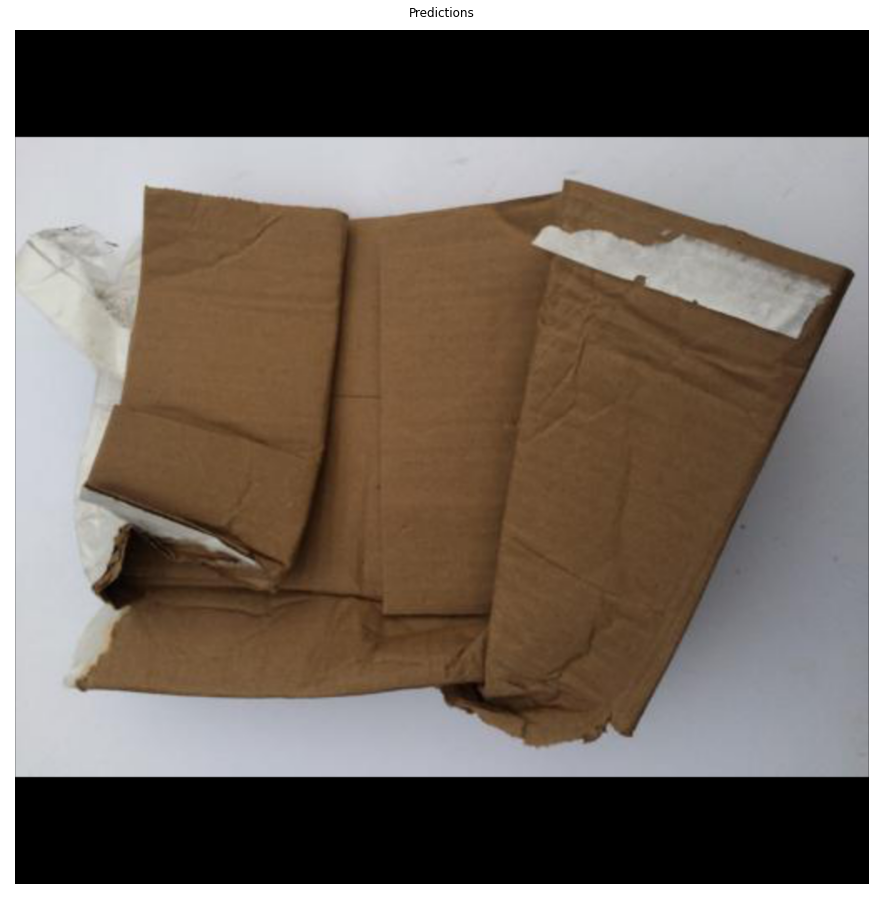

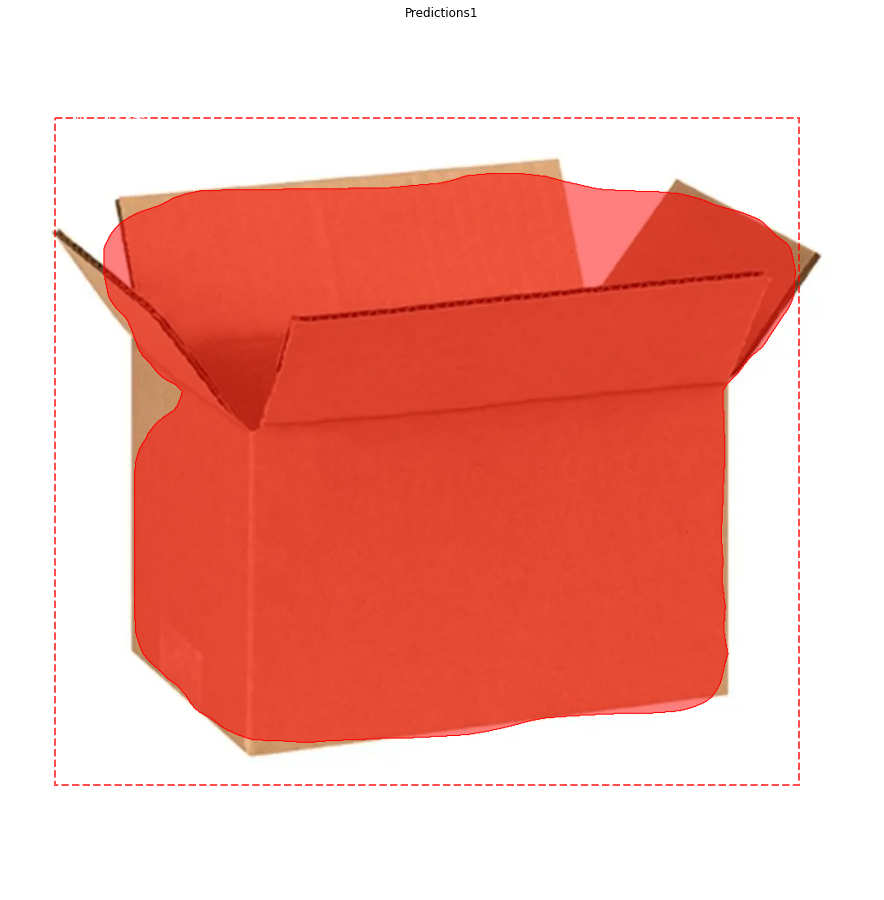

In [ ]:
image_id = random.choice(dataset.image_ids)
#print(image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
  modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
#print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)
# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], ax=ax, title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
mAP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
print("mAP = ");
print(mAP);
print(precisions);
print(recalls);

# Run object detection
path_to_new_image = '/content/drive/MyDrive/trashnet/predictie/val/cardboard2.jpg'
image1 = mpimg.imread(path_to_new_image)
#print(len([image1]))
results1 = model.detect([image1], verbose=1)
# Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")